In [4]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from matplotlib import image

import os

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_recall_curve, f1_score, auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

from tensorflow.keras.callbacks import EarlyStopping
from random import seed as base_set_seed

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical


In [5]:
# load in the data
# read in the data
f = h5py.File('bird_spectrograms.hdf5', 'r')
birds = {}
for key in f.keys():
    birds[key] = f[key]
    print(birds[key].shape)
print(birds.keys())

external_birds = np.load(os.path.join(os.getcwd(), 'output', 'preprocessing', 'test_birds.npy'))

(128, 517, 66)
(128, 517, 172)
(128, 517, 144)
(128, 517, 45)
(128, 517, 125)
(128, 517, 84)
(128, 517, 630)
(128, 517, 37)
(128, 517, 187)
(128, 517, 263)
(128, 517, 137)
(128, 517, 91)
dict_keys(['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa'])


In [6]:
# set up data for binary model American Robin vs Dark-Eyed Junco
binary_birds = np.array(["amerob", "daejun"])
binary_data = np.concatenate([birds[key] for key in binary_birds], axis=-1)
binary_data_labels = np.concatenate([np.full(birds[key].shape[-1], ind) for (ind, key) in enumerate(binary_birds)])

def binaryLabelsToBirds(labels):
    return binary_birds[labels]

# pick a sample for training and validation
n_binary_samples = binary_data.shape[-1]
test_prop = 0.2
binary_train_indices, binary_test_indices = train_test_split(np.arange(0, binary_data.shape[-1]), test_size=test_prop, random_state=112358)

binary_train_data = np.transpose(binary_data[:,:, binary_train_indices], (2, 0, 1)).reshape(-1, 128, 517, 1) # reshape and add single channel for cnn
binary_train_labels = binary_data_labels[binary_train_indices]
binary_train_data, binary_train_labels = shuffle(binary_train_data, binary_train_labels, random_state=112358)
binary_test_data = np.transpose(binary_data[:,:, binary_test_indices], (2, 0, 1)).reshape(-1, 128, 517, 1)
binary_test_labels = binary_data_labels[binary_test_indices]
binary_test_data, binary_test_labels = shuffle(binary_test_data, binary_test_labels, random_state=112358)
print(binary_test_labels.shape)
print(binary_train_labels.shape)
print(binary_test_labels[0])

# create weights for training loss relative to response class imbalance
binary_class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(binary_data_labels[binary_train_indices], axis=0), 
                                     y=binary_data_labels[binary_train_indices])
binary_class_weight_dict = {i: binary_class_weights[i] for i in range(len(binary_class_weights))}

print(binary_class_weight_dict)

(60,)
(237,)
0
{0: np.float64(0.864963503649635), 1: np.float64(1.185)}


In [7]:
# set up data for multiclass model
bird_keys = np.array(list(birds.keys()))
multiclass_data = np.concatenate([birds[key] for key in bird_keys], axis=-1)
multiclass_labels = np.concatenate([np.full(birds[key].shape[-1], ind) for (ind, key) in enumerate(bird_keys)])


def labelsToBirds(labels):
    return bird_keys[labels]

n_samples = multiclass_data.shape[-1]
test_prop = 0.2
multiclass_train_indices, multiclass_test_indices = train_test_split(np.arange(0, multiclass_data.shape[-1]),
                                                                     test_size=test_prop, random_state=112358)

multiclass_train_data = np.transpose(multiclass_data[:,:, multiclass_train_indices], (2, 0, 1)).reshape(-1, 128, 517, 1) # reshape and add single channel for cnn
multiclass_train_labels = to_categorical(multiclass_labels[multiclass_train_indices], 12)
multiclass_train_data, multiclass_train_labels = shuffle(multiclass_train_data, multiclass_train_labels, random_state=112358)
multiclass_test_data = np.transpose(multiclass_data[:,:, multiclass_test_indices], (2, 0, 1)).reshape(-1, 128, 517, 1)
multiclass_test_labels = to_categorical(multiclass_labels[multiclass_test_indices], 12)
multiclass_test_data, multiclass_test_labels = shuffle(multiclass_test_data, multiclass_test_labels, random_state=112358)
print(multiclass_test_labels.shape)
print(multiclass_train_labels.shape)
print(multiclass_test_labels[0])

# create weights for training loss relative to response class imbalance
multiclass_class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(multiclass_labels[multiclass_train_indices], axis=0), 
                                     y=multiclass_labels[multiclass_train_indices])
multiclass_class_weight_dict = {i: multiclass_class_weights[i] for i in range(len(multiclass_class_weights))}

print(multiclass_class_weight_dict)

(397, 12)
(1584, 12)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
{0: np.float64(2.4), 1: np.float64(0.9428571428571428), 2: np.float64(1.1785714285714286), 3: np.float64(3.3), 4: np.float64(1.375), 5: np.float64(2.0307692307692307), 6: np.float64(0.26294820717131473), 7: np.float64(4.551724137931035), 8: np.float64(0.8859060402684564), 9: np.float64(0.616822429906542), 10: np.float64(1.2), 11: np.float64(1.8333333333333333)}


In [8]:
#train binary model on full data set with the chosen parameters and epochs
conv_kernel = (7,7)
dropout_rate = 0.1
start_filter_cnt = 16
epochs = 40
batch_size = 40

binary_cnn = Sequential(
    [
    Conv2D(filters=start_filter_cnt, kernel_size=conv_kernel, padding='same', activation='relu', input_shape=(128,517, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=start_filter_cnt*2, kernel_size=conv_kernel, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=start_filter_cnt*3, kernel_size=conv_kernel, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=start_filter_cnt*4, kernel_size=conv_kernel, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(rate=dropout_rate),
    Dense(units=512, activation='relu'),
    Dense(units=1, activation='sigmoid')
    ])

binary_cnn.compile(loss='binary_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])

binary_history = binary_cnn.fit(binary_train_data, binary_train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(binary_test_data, binary_test_labels),
                    verbose=1,
                    class_weight=binary_class_weight_dict)


c:\Users\ellin\miniconda3\envs\keras_dl\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 465ms/step - accuracy: 0.5240 - loss: 941.7971 - val_accuracy: 0.4167 - val_loss: 0.9753
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - accuracy: 0.4245 - loss: 1.7268 - val_accuracy: 0.4167 - val_loss: 0.6985
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.5185 - loss: 0.6924 - val_accuracy: 0.4167 - val_loss: 0.7038
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - accuracy: 0.5297 - loss: 0.6890 - val_accuracy: 0.5833 - val_loss: 1.0662
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - accuracy: 0.4861 - loss: 1.0675 - val_accuracy: 0.4167 - val_loss: 0.6989
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - accuracy: 0.4660 - loss: 0.7039 - val_accuracy: 0.5667 - val_loss: 0.6896
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - accuracy: 0.4821 - loss: 0.7101 - val_accuracy: 0.6000 - val_loss: 0.6794
Epoch 8/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 613ms/step - accuracy: 0.5305 - loss: 0.6875 - val_accuracy: 0.5833 - val_los

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Test Accuracy: 78.33%
Average Test Precision: 0.779
Average Test Recall: 0.786
Average Test F1-score: 0.780


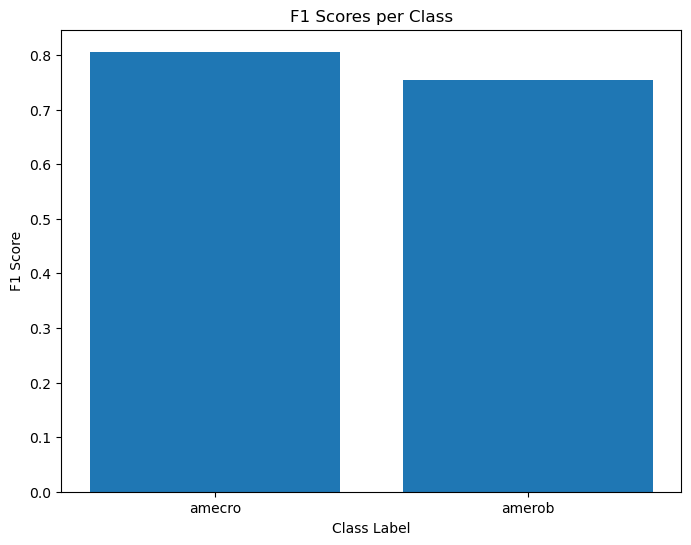

In [22]:
# accuracy, precision, recall, f1, and the confusion matrix
binary_pred = (binary_cnn.predict(binary_test_data) > 0.5)

test_accuracy = accuracy_score(binary_test_labels, binary_pred)
precision, recall, f1, _ = precision_recall_fscore_support(binary_test_labels, binary_pred, average='macro')

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Average Test Precision: {precision:.3f}")
print(f"Average Test Recall: {recall:.3f}")
print(f"Average Test F1-score: {f1:.3f}")
binary_test_performances = pd.Series({'accuracy':test_accuracy, 'average_precision':precision,
                            'average_recall':recall, 'average_f1':f1}, index=['accuracy', 'average_precision',
                                                                                'average_recall', 'average_f1'])
binary_test_performances.to_csv(os.path.join(os.getcwd(), 'output', 'analysis', 'data', 'binary_cnn_test_metrics.csv'), index=True)
binary_cm = confusion_matrix(binary_test_labels, binary_pred)
binary_cm_labels = binaryLabelsToBirds([0, 1])
binary_df_cm = pd.DataFrame(binary_cm, index=binary_cm_labels, columns=binary_cm_labels)
binary_df_cm.to_csv(os.path.join(os.getcwd(), 'output', 'analysis', 'data', 'binary_cnn_confusion_matrix.csv'))

f1_scores = f1_score(binary_test_labels, binary_pred, average=None)
plt.figure(figsize=(8, 6))
f1_labels = labelsToBirds(np.arange(len(f1_scores)))
plt.bar(f1_labels, f1_scores)
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.title("F1 Scores per Class")
plt.savefig(os.path.join(os.getcwd(), 'output', 'analysis', 'plots', 'binary_f1_per_class.png'))
plt.show()

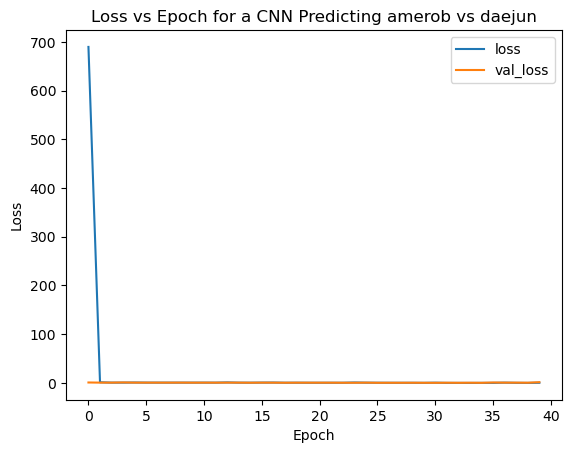

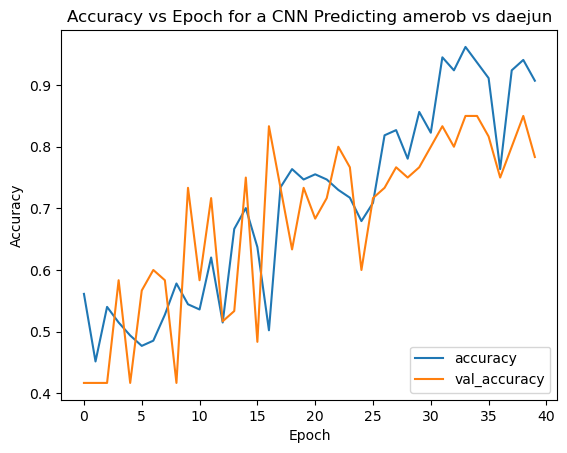

C:\Users\ellin\AppData\Local\Temp\ipykernel_34492\1410366348.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


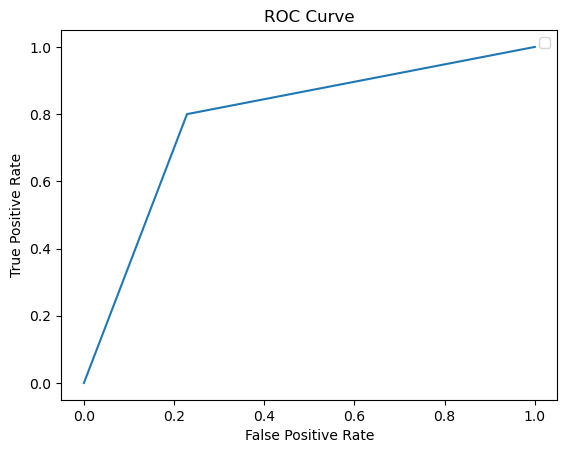

In [16]:
# create plots for loss, accuracy, vs epoch
out_dir = os.path.join(os.getcwd(), 'output', 'analysis', 'plots')
plt.plot(binary_history.history['loss'])
plt.plot(binary_history.history['val_loss'])
plt.title('Loss vs Epoch for a CNN Predicting amerob vs daejun')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig(os.path.join(out_dir, f'binary_cnn_loss_vs_epoch.png'))
plt.show()

plt.plot(binary_history.history['accuracy'])
plt.plot(binary_history.history['val_accuracy'])
plt.title('Accuracy vs Epoch for a CNN Predicting amerob vs daejun')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.savefig(os.path.join(out_dir, f'binary_cnn_accuracy_vs_epoch.png'))
plt.show()

FPR, TPR, _ = roc_curve(binary_test_labels, binary_pred, pos_label=1)
plt.plot(FPR, TPR)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(os.path.join(out_dir, f'binary_cnn_roc_curve.png'))
plt.show()

In [17]:
# train multiclass model on full data set with chosen parameters and choose epochs
conv_kernel = (7,7)
dropout_rate = 0.1
start_filter_cnt = 16
epochs = 100 # still need to tune this for the full data set
batch_size = 200 # splits ~1600 training examples rather nicely

multiclass_cnn = Sequential(
    [
    Conv2D(filters=start_filter_cnt, kernel_size=conv_kernel, padding='same', activation='relu', input_shape=(128,517, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=start_filter_cnt*2, kernel_size=conv_kernel, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=start_filter_cnt*3, kernel_size=conv_kernel, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=start_filter_cnt*4, kernel_size=conv_kernel, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(rate=dropout_rate),
    Dense(units=512, activation='relu'),
    Dense(units=12, activation='softmax')
    ])

multiclass_cnn.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])


multiclass_history = multiclass_cnn.fit(multiclass_train_data, multiclass_train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(multiclass_test_data, multiclass_test_labels),
                    verbose=1,
                    class_weight=multiclass_class_weight_dict)

c:\Users\ellin\miniconda3\envs\keras_dl\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.0997 - loss: 111.8326 - val_accuracy: 0.1259 - val_loss: 2.4785
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.0972 - loss: 2.4438 - val_accuracy: 0.2368 - val_loss: 2.4656
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.2221 - loss: 2.4237 - val_accuracy: 0.1108 - val_loss: 2.4774
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.1221 - loss: 2.4902 - val_accuracy: 0.0479 - val_loss: 2.4936
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0456 - loss: 2.5421 - val_accuracy: 0.0126 - val_loss: 2.4950
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0245 - loss: 2.5423 - val_accuracy: 0.0277 - val_loss: 2.4897
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0519 - loss: 2.3995 - val_accuracy: 0.0630 - val_loss: 2.4943
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0521 - loss: 2.4472 - val_accuracy: 0.0529 - val_loss: 2.489

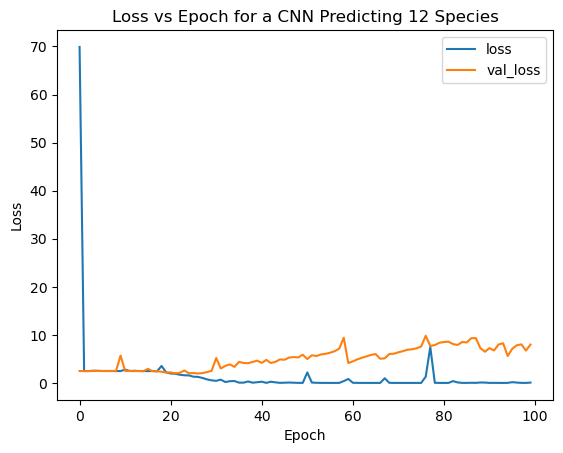

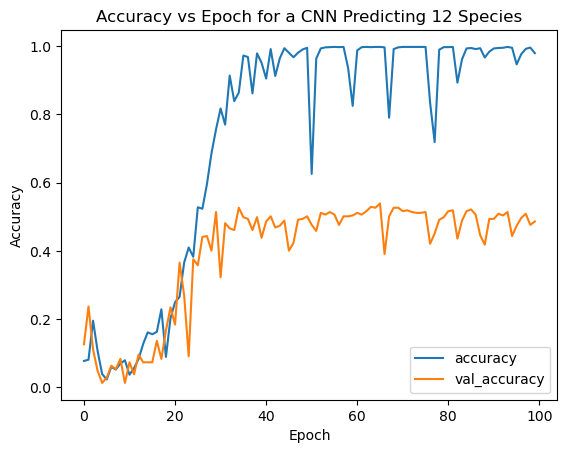

In [18]:
out_dir = os.path.join(os.getcwd(), 'output', 'analysis', 'plots')
plt.plot(multiclass_history.history['loss'])
plt.plot(multiclass_history.history['val_loss'])
plt.title('Loss vs Epoch for a CNN Predicting 12 Species')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig(os.path.join(out_dir, f'multiclass_cnn_loss_vs_epoch.png'))
plt.show()

plt.plot(multiclass_history.history['accuracy'])
plt.plot(multiclass_history.history['val_accuracy'])
plt.title('Accuracy vs Epoch for a CNN Predicting 12 Species')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.savefig(os.path.join(out_dir, f'multiclass_cnn_accuracy_vs_epoch.png'))
plt.show()


In [20]:
# train multiclass model on full dataset with the chosen epochs
conv_kernel = (7,7)
dropout_rate = 0.1
start_filter_cnt = 16
epochs = 35
batch_size = 200 # splits ~1600 training examples rather nicely

multiclass_cnn = Sequential(
    [
    Conv2D(filters=start_filter_cnt, kernel_size=conv_kernel, padding='same', activation='relu', input_shape=(128,517, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=start_filter_cnt*2, kernel_size=conv_kernel, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=start_filter_cnt*3, kernel_size=conv_kernel, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=start_filter_cnt*4, kernel_size=conv_kernel, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(rate=dropout_rate),
    Dense(units=512, activation='relu'),
    Dense(units=12, activation='softmax')
    ])

multiclass_cnn.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])


multiclass_history = multiclass_cnn.fit(multiclass_train_data, multiclass_train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(multiclass_test_data, multiclass_test_labels),
                    verbose=1,
                    class_weight=multiclass_class_weight_dict)

Epoch 1/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.0949 - loss: 65.6279 - val_accuracy: 0.0302 - val_loss: 2.4882
Epoch 2/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.0440 - loss: 2.4744 - val_accuracy: 0.0730 - val_loss: 2.4842
Epoch 3/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0633 - loss: 2.4390 - val_accuracy: 0.0630 - val_loss: 2.4828
Epoch 4/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0675 - loss: 2.5017 - val_accuracy: 0.0856 - val_loss: 2.4802
Epoch 5/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.1140 - loss: 2.4828 - val_accuracy: 0.0907 - val_loss: 2.4731
Epoch 6/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.1274 - loss: 2.4798 - val_accuracy: 0.0932 - val_loss: 2.4782
Epoch 7/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.1371 - loss: 2.4715 - val_accuracy: 0.1033 - val_loss: 2.4719
Epoch 8/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0956 - loss: 2.5354 - val_accuracy: 0.0831 - val_loss: 2.4851
Epoch 9

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


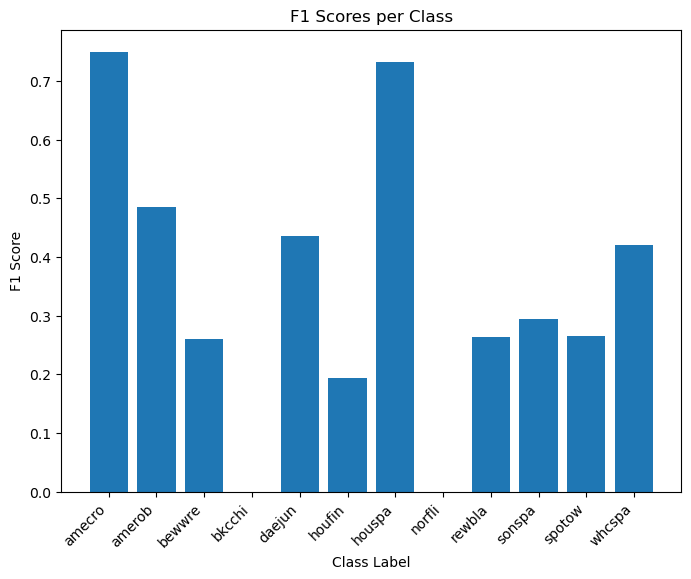

        amecro  amerob  bewwre  bkcchi  daejun  houfin  houspa  norfli  \
amecro       9       0       0       0       0       0       0       1   
amerob       0      17       3       0       1       1       4       1   
bewwre       0       2      10       0       5       1       5       0   
bkcchi       0       1       1       0       0       0       1       0   
daejun       1       0       1       1      17       0       1       0   
houfin       0       3       1       0       1       3       8       0   
houspa       1       5       6       0      10       0      96       1   
norfli       1       1       0       0       1       0       2       0   
rewbla       0       4       4       1       3       2       9       0   
sonspa       0       3      14       3       6       3       1       0   
spotow       1       0       3       3       3       2       5       0   
whcspa       0       2       2       0       2       0       2       1   

        rewbla  sonspa  spotow  whcsp

In [26]:
# save loss, accuracy, average precision, average recall, average f1, the confusion matrix, and the normalized-by-row confusion matrix
multiclass_pred = multiclass_cnn.predict(multiclass_test_data)

multiclass_true_classes = np.argmax(multiclass_test_labels, axis=1)
multiclass_pred = np.argmax(multiclass_pred, axis=1)
test_accuracy = accuracy_score(multiclass_true_classes, multiclass_pred)
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(multiclass_true_classes, multiclass_pred, average='macro')
f1_scores = f1_score(multiclass_true_classes, multiclass_pred, average=None)
plt.figure(figsize=(8, 6))
f1_labels = labelsToBirds(np.arange(len(f1_scores)))
plt.bar(f1_labels, f1_scores)
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.title("F1 Scores per Class")
plt.xticks(rotation=45, ha="right")
plt.savefig(os.path.join(os.getcwd(), 'output', 'analysis', 'plots', 'multiclass_f1_per_class.png'))
plt.show()

pd.Series([test_accuracy, avg_precision, avg_recall, avg_f1], index=["Test Accuracy", "Avg Precision", "Avg Recall", "Avg F1"]).to_csv(
    os.path.join(os.getcwd(), 'output', 'analysis', 'data', 'multiclass_overall_test_metrics.csv')
)
pd.Series(f1_scores, index=f1_labels).to_csv(os.path.join(os.getcwd(), 'output', 'analysis', 'data', 'multiclass_f1_per_class.csv'))

multiclass_cm = confusion_matrix(multiclass_true_classes, multiclass_pred)
norm_multiclass_cm = multiclass_cm.astype('float') / multiclass_cm.sum(axis=1, keepdims=True)
multiclass_cm = pd.DataFrame(multiclass_cm, index=bird_keys, columns=bird_keys)
print(multiclass_cm)
multiclass_cm.to_csv(
    os.path.join(os.getcwd(), 'output', 'analysis', 'data', 'multiclass_confusion_matrix.csv'),
    index=True
)
norm_multiclass_cm = pd.DataFrame(norm_multiclass_cm, index=bird_keys, columns=bird_keys)
print(norm_multiclass_cm)
norm_multiclass_cm.to_csv(
    os.path.join(os.getcwd(), 'output', 'analysis', 'data', 'multiclass_confusion_matrix_normalized.csv'),
    index=True
) 

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Average Test Precision: {precision:.3f}")
print(f"Average Test Recall: {recall:.3f}")
print(f"Average Test F1-score: {f1:.3f}")


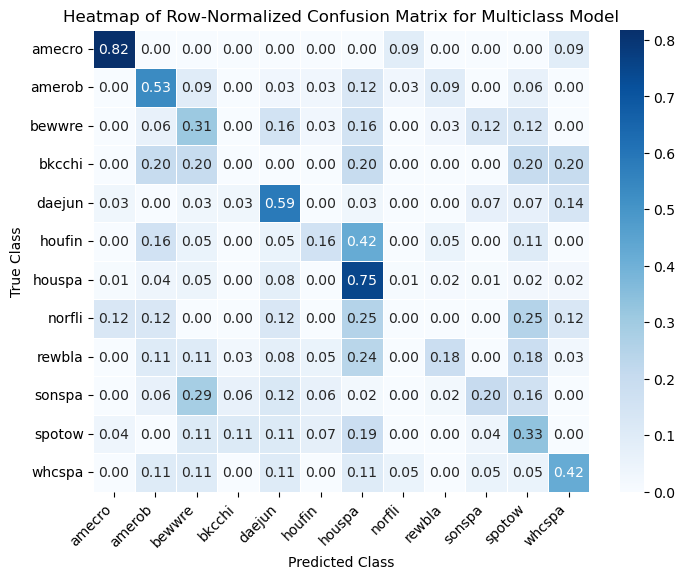

In [35]:
# heat
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(norm_multiclass_cm, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.xlabel("Predicted Class")
plt.xticks(rotation=45, ha="right")
plt.ylabel("True Class")
plt.title("Heatmap of Row-Normalized Confusion Matrix for Multiclass Model")
plt.savefig(os.path.join(os.getcwd(), 'output', 'analysis', 'plots', 'heatmap_norm_cm_multiclass.png'))
plt.show()

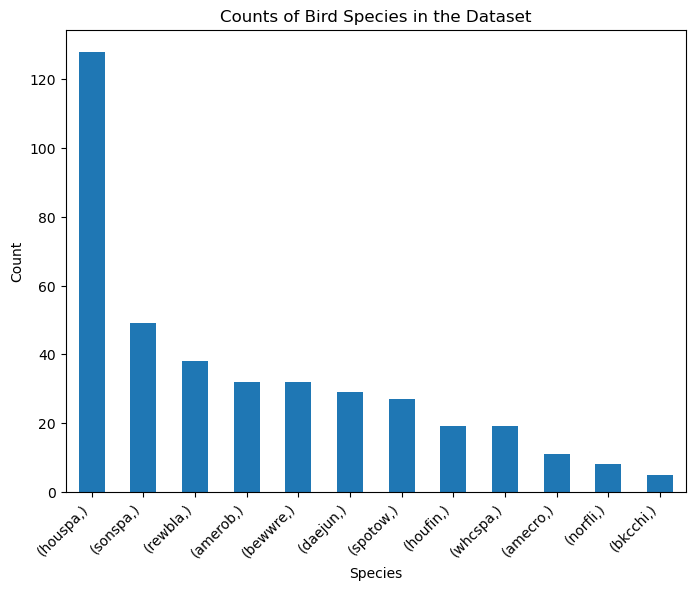

In [38]:
# frequency bar chart for response classes
species_cnts = pd.DataFrame({"species":labelsToBirds(multiclass_true_classes)}).value_counts()

plt.figure(figsize=(8,6))
species_cnts.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.xlabel("Species")
plt.title("Counts of Bird Species in the Dataset")
plt.savefig(os.path.join(os.getcwd(), 'output', 'analysis', 'plots', 'species_cnts_bar.png'))
plt.show()

In [ ]:
# use model to produce probability predictions for the external test data
external_birds = external_birds.transpose((2, 0, 1)).reshape((-1, 128, 517, 1))
external_pred = multiclass_cnn.predict(external_birds)
print(external_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[0.05821041 0.05274783 0.029848   0.02131792 0.05516155 0.03459938
  0.4392951  0.03763865 0.0916114  0.02287105 0.12462272 0.03207606]
 [0.00483998 0.02445438 0.02008304 0.00307138 0.02260798 0.00565125
  0.29302567 0.1560297  0.4148979  0.01248235 0.00258024 0.04027614]
 [0.00527316 0.00528619 0.02661655 0.06311281 0.00165162 0.07057115
  0.30460307 0.00444938 0.111053   0.00781711 0.38149098 0.01807493]]


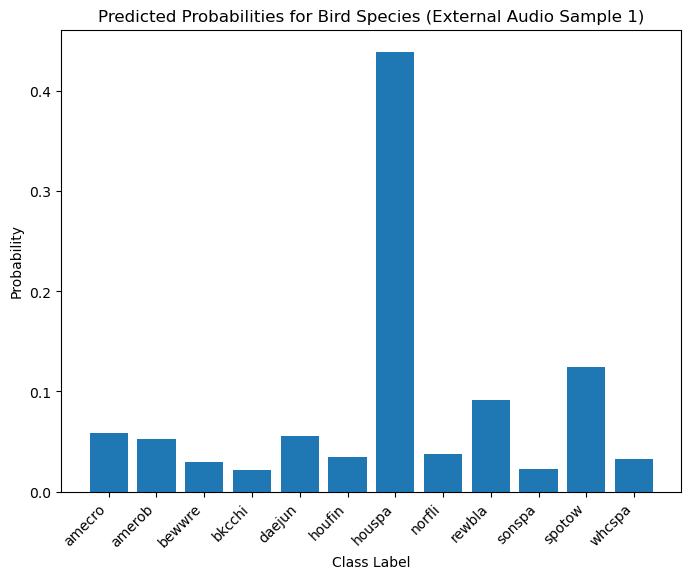

In [29]:
# plot of external example 1 probabilities
plt.figure(figsize=(8,6))
plt.bar(bird_keys, external_pred[0])
plt.xlabel("Class Label")
plt.ylabel("Probability")
plt.title("Predicted Probabilities for Bird Species (External Audio Sample 1)")
plt.xticks(rotation=45, ha="right")
plt.savefig(os.path.join(os.getcwd(), 'output', 'analysis', 'plots', 'predictions_external_sample_1.png'))
plt.show()

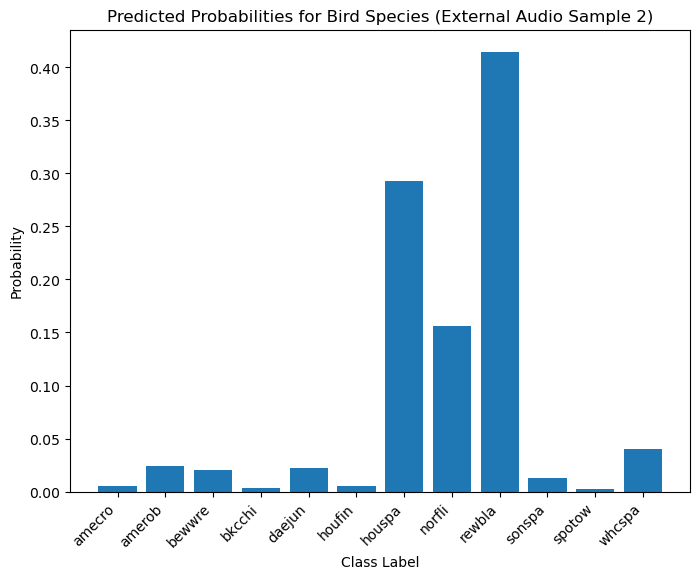

In [30]:
plt.figure(figsize=(8,6))
plt.bar(bird_keys, external_pred[1])
plt.xlabel("Class Label")
plt.ylabel("Probability")
plt.title("Predicted Probabilities for Bird Species (External Audio Sample 2)")
plt.xticks(rotation=45, ha="right")
plt.savefig(os.path.join(os.getcwd(), 'output', 'analysis', 'plots', 'predictions_external_sample_2.png'))
plt.show()

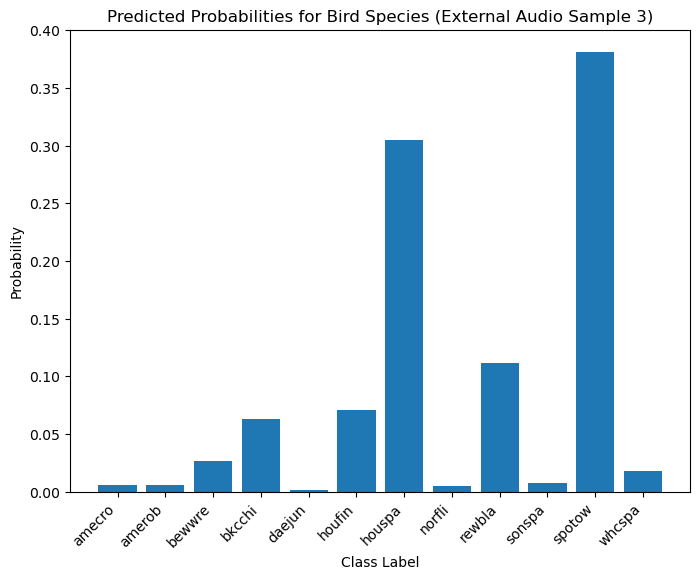

In [31]:
plt.figure(figsize=(8,6))
plt.bar(bird_keys, external_pred[2])
plt.xlabel("Class Label")
plt.ylabel("Probability")
plt.title("Predicted Probabilities for Bird Species (External Audio Sample 3)")
plt.xticks(rotation=45, ha="right")
plt.savefig(os.path.join(os.getcwd(), 'output', 'analysis', 'plots', 'predictions_external_sample_3.png'))
plt.show()